# 現場のプロが伝える前処理技術 Chapter2

## chapter 2-5　カテゴリカル変数の処理

文字列をそのママ機械学習で使う事は出来ないので、数値に変換する必要があります。  
カテゴリ変数に関しては、順序尺度が関係あれば順序ラベルエンコーディング、関係なければOneHotエンコーディングで基本問題ない。  
ユニーク地が多い場合には、ターゲットエンコーディングを考える。

**尺度の種類**
- 名義尺度 : 大小関係ない、名前そのものに関係あり。 性別とか
- 順序尺度 : 大小関係あり、その感覚には意味はない。 服のサイズとか
- 間隔尺度 : 大小関係あり、間隔に意味はあるが、比較には関係なし。  摂氏温度とか
- 比尺度  :  大小関係あり、間隔、比較にも意味がある。 年齢、体重とか

In [1]:
import pandas as pd

df = pd.DataFrame({'SIZE':['L', 'M', 'S', 'L'],
                  "PRICE":["250", '200', '150', '250']
                  })

df

,SIZE,PRICE
0,L,250
1,M,200
2,S,150
3,L,250


### 順序ラベル・エンコーディング

In [2]:
#category encoder インポート
import category_encoders as ce
#マップを辞書で学習
mapping = [{'col': 'SIZE', 'mapping': {'S': 0, 'M': 1, 'L': 2}}]
#エンコーダーをインスタンス化
enc = ce.OrdinalEncoder(mapping=mapping)
#マップを学習
enc.fit(df)
#変換
enc.transform(df)

ModuleNotFoundError: No module named 'category_encoders'

### One-hotエンコーディング

In [3]:
#df_adultを読み込む
df_adult_m = pd.read_csv('./genbapro_preprocessing/chapter2-data/adult.data', header=None)
df_adult_m.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum", "MaritalStatus",
    "Occupation", "Relationship", "Race", "Gender", "CapitalGain",
    "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]
df_adult = df_adult_m.copy()

#OneHotEncoder 1インスタンス化
#use_cat_names をTrueとすることで変数名が元のカテゴリ名に対応する
encoder = ce.OneHotEncoder(use_cat_names=True)
#学習
encoder.fit_transform(df_adult['MaritalStatus'])

NameError: name 'ce' is not defined

In [4]:
#購買トランザクション読み込み
df = pd.read_csv('./genbapro_preprocessing/chapter2-data/sales201907.csv')
df

,顧客ID,購買日時,商品名,数量,金額,更新日時
0,10001,2019/7/1,A,1,100,2019/7/1
1,10001,2019/7/1,B,2,300,2019/7/1
2,10002,2019/7/1,A,2,200,2019/7/1
3,10002,2019/7/1,B,2,300,2019/7/1
4,10002,2019/7/1,C,1,200,2019/7/1
5,10003,2019/7/1,D,1,250,2019/7/1


In [5]:
encoder = ce.OneHotEncoder(use_cat_names=True)

df_enc = encoder.fit_transform(df.drop("購買日時", axis=1))
df_enc

NameError: name 'ce' is not defined

In [6]:
# ピボットテーブル
pd.pivot_table(df_enc, index="顧客ID", aggfunc="sum")

NameError: name 'df_enc' is not defined

### ターゲットエンコーディング

web履歴情報など非常に多くのユニーク値を持つ場合に目的変数の情報を利用し、  
カテゴリカル変数を数値に変換する方法で、Kaggle等の機械学習コンペではよく用いられているようです。  
目的変数がBoolean表現の場合、カテゴリごとの確率を、数値であればカテゴリごとの平均を特徴量とします。  

注意事項:学習ありモデルにしか使用できない。

In [7]:
from sklearn.model_selection import train_test_split

X = df_adult["NativeCountry"]

# 教師データのOneHotコーディング
encoder = ce.OneHotEncoder(use_cat_names=True)
y = encoder.fit_transform(df_adult["Income"]).iloc[:,1]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

encoder = ce.TargetEncoder()
encoder.fit(x_train, y_train)
x_train_enc = encoder.transform(x_train)
x_test_enc = encoder.transform(x_test)

x_train_enc.head()

NameError: name 'ce' is not defined

In [8]:
pd.concat([x_train, x_train_enc], axis=1).drop_duplicates().head()

NameError: name 'x_train' is not defined

# Chapter 2-6 欠損値の処理

欠損の発生メカニズムは３つの種類がある。
- MCAR : 完全なランダムなエラー
- MAR  : 欠損が起きている変数と異なる別の変数の値によって欠損がランダムに発生する場合。
- NMAR : 欠損が起きている変数そのものの値によって欠損率が変わる場合。

MCARは欠損であることに余りなんの意味ももたなにので比較的簡単に処理できるが、  
他は処理が大変なので出来るだけ欠損ができないようにデータ収集を行う。

### サンプルデータの作成

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import category_encoders as ce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import missingno as mno

########################
#サンプルデータ  準備
#Adult Data Set
########################
df_adult = df_adult_m.copy()

#欠損率を20%と設定
p = 0.2
#架空の欠損データ生成
from numpy.random import *
seed(1)
x = pd.Series(np.random.uniform(0.0, 1.0, len(df_adult)))
x.index = df_adult.index

#MCAR作成
df_adult['Age_mcar'] = np.where(x < p, np.nan, df_adult['Age'])

#MAR作成
#全体の欠損率が20%、女性の欠損率が30%となるように設定
p_f = 0.3
p_m = (round(len(df_adult) * p) - df_adult.Gender.value_counts()[1] * p_f
       ) / df_adult.Gender.value_counts()[0]

#男性
ix = df_adult['Gender'] == ' Male'
seed(2)
x = pd.Series(np.random.uniform(0.0, 1.0, len(df_adult)))
x.index = df_adult.index
df_adult['Age_mar'] = np.where((x < p_m) & (ix), np.nan, df_adult['Age'])

#女性
ix = df_adult['Gender'] == ' Male'
seed(3)
x = pd.Series(np.random.uniform(0.0, 1.0, len(df_adult)))
x.index = df_adult.index
df_adult['Age_mar'] = np.where((x < p_f) & (~ix), np.nan, df_adult['Age_mar'])

#MNAR
#40歳以上の一部を欠損とする
ix = df_adult['Age'] >= 40
p_40 = round(len(df_adult) * p) / (ix).sum()
seed(4)
x = pd.Series(np.random.uniform(0.0, 1.0, len(df_adult)))
x.index = df_adult.index
#30%欠損
df_adult['Age_mnar'] = np.where((x < p_40) & (ix), np.nan, df_adult['Age'])

df_adult.head(10)

ModuleNotFoundError: No module named 'category_encoders'

### エンコーディング処理

In [14]:
# Incom変数 = 1/0エンコーディング
df_adult["Income"] = (df_adult["Income"] == ' >50K').astype(int)

X_adult = df_adult.drop(["Income"], axis=1)
y_adult = df_adult["Income"]

X_adult_train, X_adult_test, y_adult_train, y_adult_test = train_test_split(
    X_adult, y_adult, test_size=0.2, random_state=1)

# ターゲットエンコーダ インスタンス化
encoder = ce.TargetEncoder(cols=['Education', 'Occupation', 'NativeCountry'])
enc = encoder.fit(X_adult_train, y_adult_train)
X_adult_train = enc.transform(X_adult_train)
X_adult_test = enc.transform(X_adult_test)

# One_hotエンコーディング インスタンス化
encoder = ce.OneHotEncoder(
    cols =['WorkClass', 'MaritalStatus', 'Relationship', 'Race', 'Gender'],
    use_cat_names=True)
enc = encoder.fit(X_adult_train)
X_adult_train = enc.transform(X_adult_train)
X_adult_test = enc.transform(X_adult_test)

#One-Hotで冗長になった変数を落とす
drop_l = [
    [col for col in X_adult_train.columns if col.find('WorkClass') >= 0][0], \
    [col for col in X_adult_train.columns if col.find('MaritalStatus') >= 0][0], 
    [col for col in X_adult_train.columns if col.find('Relationship') >= 0][0], 
    [col for col in X_adult_train.columns if col.find('Race') >= 0][0],
    [col for col in X_adult_train.columns if col.find('Gender') >= 0][0]
]

X_adult_train = X_adult_train.drop(drop_l, axis=1)
X_adult_test = X_adult_test.drop(drop_l, axis=1)

NameError: name 'ce' is not defined

In [15]:
mno.matrix(df_adult, figsize=(20,6))

NameError: name 'mno' is not defined

## 欠損の除去

### リストワイズ除去法  
欠損が発生している行を削除し完全データを作る方法。  
簡単な方法ですが、MCAR以外に適用すると不適切な事がわかっている。

In [16]:
X_adult_train_mcar = X_adult_train.drop(['Age','Age_mar','Age_mnar'],axis=1)
# print (X_adult_train_mcar.isnull().sum())

#行を落とす
X_adult_train_mcar_dropnar = X_adult_train_mcar.dropna()
# print (X_adult_train_mcar_dropnar.isnull().sum())

#列を落とす(axis=1オプション)
X_adult_train_mcar_dropnac = X_adult_train_mcar.dropna(axis=1)
print (X_adult_train_mcar_dropnac.isnull().sum())

KeyError: "['Age_mar' 'Age_mnar'] not found in axis"

## 欠損値に定数を入れる

In [17]:
#欠損埋めモジュール
from sklearn.impute import SimpleImputer

X_adult_train_fillna = X_adult_train.copy()
X_adult_test_fillna = X_adult_test.copy()
# print(X_adult_test_fillna.isnull().sum())


#平均値で埋める ------------------------------
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
missing_cols = ['Age_mcar', 'Age_mar', 'Age_mnar']

#訓練データから平均値を算出
imputer.fit(X_adult_train_fillna[missing_cols])

#訓練データに算出した値を追記（columnsの変更、データフレーム化、平均値での欠損値処理を行っている。）
X_adult_train_fillna[[col + '_mean' for col in missing_cols]] = pd.DataFrame(
    imputer.transform(X_adult_train_fillna[missing_cols]),
    index=X_adult_train.index)

#テストデータも訓練データ同様処理
X_adult_test_fillna[[col + '_mean' for col in missing_cols]] = pd.DataFrame(
    imputer.transform(X_adult_test_fillna[missing_cols]),
    index=X_adult_test.index)

# X_adult_test_fillna.isnull().sum()


#中央値で埋める(基本平均値と同じ処理）-------------------------------
# strategy を median に変えるのみ。
imputer = SimpleImputer(missing_values=np.nan, strategy='median') 
missing_cols = ['Age_mcar', 'Age_mar', 'Age_mnar']
imputer.fit(X_adult_train_fillna[missing_cols])

#訓練データ
X_adult_train_fillna[[col + '_median' for col in missing_cols]] = pd.DataFrame(
    imputer.transform(X_adult_train_fillna[missing_cols]),
    index=X_adult_train.index)
#テストデータ
X_adult_test_fillna[[col + '_median' for col in missing_cols]] = pd.DataFrame(
    imputer.transform(X_adult_test_fillna[missing_cols]),
    index=X_adult_test.index)


#最頻値で埋める(基本平均値と同じ処理）-------------------------------
# strategy を most_frequent に変えるのみ。
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
missing_cols = ['Age_mcar', 'Age_mar', 'Age_mnar']
imputer.fit(X_adult_train_fillna[missing_cols])
#訓練データ
X_adult_train_fillna[[col + '_mode' for col in missing_cols]] = pd.DataFrame(
    imputer.transform(X_adult_train_fillna[missing_cols]),
    index=X_adult_train.index)
#テストデータ
X_adult_test_fillna[[col + '_mode' for col in missing_cols]] = pd.DataFrame(
    imputer.transform(X_adult_test_fillna[missing_cols]),
    index=X_adult_test.index)

NameError: name 'np' is not defined

In [18]:
X_adult_test_fillna.isnull().sum()

Age              0
WorkClass        0
fnlwgt           0
Education        0
EducationNum     0
MaritalStatus    0
Occupation       0
Relationship     0
Race             0
Gender           0
CapitalGain      0
CapitalLoss      0
HoursPerWeek     0
NativeCountry    0
dtype: int64

In [19]:
#MARの代入前後の分布
plt.figure(figsize=(14, 7))
for i, col in enumerate(
    ['Age_mar', 'Age_mcar_mean', 'Age_mcar_median', 'Age_mcar_mode']):
    plt.subplot(2, 2, i + 1)
    plt.hist(
        X_adult_train_fillna['Age'],
        alpha=0.7,
        label='Complete Data',
        bins=range(0, 100, 10))
    plt.legend()
    plt.hist(X_adult_train_fillna[col], alpha=0.7, bins=range(0, 100, 10))
    plt.grid()
    plt.title(col)
    plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

NameError: name 'plt' is not defined

## 欠損値に予測値を入れる。

### 回帰代入法  
わかっている特徴量から欠損している特徴量を回帰式で求めて代入する。

In [20]:
#sklearnのLinearRegressionモジュール読み込む
from sklearn.linear_model import LinearRegression
#線形回帰のインスタンス化
reg1 = LinearRegression()
reg2 = LinearRegression()
reg3 = LinearRegression()

#MCARに対して処理を実行
#使用しない特徴量のリスト特にターゲットエンコーディングした特徴量は除く

# MCARの欠損値の判定(ix)Trueが欠損値。
ix = X_adult_train['Age_mcar'].isnull()
drop = ['Education', 'Occupation', 'NativeCountry'
        ] + ['Age', 'Age_mcar', 'Age_mar', 'Age_mnar', 'fnlwgt']
x1 = X_adult_train[~ix].drop(drop, axis=1)
x2 = X_adult_train.loc[x1.index, 'Age_mcar']

#線形回帰
# MCARの値があるdrop以外の特徴量と、正解ラベルにMCARを指定して学習
reg1.fit(x1, x2)

#訓練データ予測する-----------------------------------------
#dropの特徴量を除くMCARの欠損値から推定する。
X_adult_train_fillna['Age_mcar_reg'] = pd.Series(
    reg1.predict(X_adult_train[ix].drop(drop, axis=1)),
    X_adult_train[ix].index)

#Age_mcar_regには、欠損値を推定した値で代入した値しかないので元の値をAgeから代入する。
X_adult_train_fillna['Age_mcar_reg'] = \
    X_adult_train_fillna['Age_mcar_reg'].fillna(X_adult_train_fillna['Age'])

#検証データ予測する(訓練データと同じ)---------------------------
ixt = X_adult_test['Age_mcar'].isnull()
X_adult_test_fillna['Age_mcar_reg'] = pd.Series(
    reg1.predict(X_adult_test[ixt].drop(drop, axis=1)),
    X_adult_test[ixt].index)
X_adult_test_fillna['Age_mcar_reg'] = \
    X_adult_test_fillna['Age_mcar_reg'].fillna(X_adult_test_fillna['Age'])

# 同様にMAR,NMARも欠損値代入を行う。

KeyError: 'Age_mcar'

In [21]:
#MARの代入前後の分布
plt.figure(figsize=(14, 7))
for i, col in enumerate(['Age_mcar', 'Age_mcar_reg']):
    plt.subplot(2, 2, i + 1)
    plt.hist(
        X_adult_train_fillna['Age'],
        alpha=0.7,
        label='Complete Data',
        bins=range(0, 100, 10))
    plt.legend()
    plt.hist(X_adult_train_fillna[col], alpha=0.7, bins=range(0, 100, 10))
    plt.grid()
    plt.title(col)
    plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

NameError: name 'plt' is not defined

## 多重代入法

定数、予測値の代入では決まった値を１つ代入して完全データとしてました。  
多重代入法では、サンプリングにより作成した複数のデータを用いて結合した値を代入します。

In [22]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

IterativeImputer公式URL  
https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

In [23]:
##################MCAR 埋める##################
#使用しない特徴量のリスト特にターゲットエンコーディングした特徴量は除く
drop = ['Education', 'Occupation', 'NativeCountry'
        ] + ['Age', 'Age_mar', 'Age_mnar', 'fnlwgt']

#IterativeImputerインスタンス化
imputer = IterativeImputer(max_iter=5, sample_posterior=True, random_state=123)

#訓練
imputer.fit(X_adult_train.drop(drop, axis=1))
#訓練データに代入
X_adult_train_fillna['Age_mcar_itr'] = pd.DataFrame(
    imputer.transform(X_adult_train.drop(drop, axis=1)),
    index=X_adult_train.drop(drop, axis=1).index,
    columns=X_adult_train.drop(drop, axis=1).columns)['Age_mcar']

#検証データに代入
X_adult_test_fillna['Age_mcar_itr'] = pd.DataFrame(
    imputer.transform(X_adult_test.drop(drop, axis=1)),
    index=X_adult_test.drop(drop, axis=1).index,
    columns=X_adult_test.drop(drop, axis=1).columns)['Age_mcar']

##################MAR 埋める##################
#使用しない特徴量のリスト特にターゲットエンコーディングした特徴量は除く
drop = ['Education', 'Occupation', 'NativeCountry'
        ] + ['Age', 'Age_mcar', 'Age_mnar', 'fnlwgt']

#IterativeImputerインスタンス化
imputer = IterativeImputer(max_iter=5, sample_posterior=True, random_state=123)
#訓練
imputer.fit(X_adult_train.drop(drop, axis=1))
#訓練データに代入
X_adult_train_fillna['Age_mar_itr'] = pd.DataFrame(
    imputer.transform(X_adult_train.drop(drop, axis=1)),
    index=X_adult_train.drop(drop, axis=1).index,
    columns=X_adult_train.drop(drop, axis=1).columns)['Age_mar']

#検証データに代入
X_adult_test_fillna['Age_mar_itr'] = pd.DataFrame(
    imputer.transform(X_adult_test.drop(drop, axis=1)),
    index=X_adult_test.drop(drop, axis=1).index,
    columns=X_adult_test.drop(drop, axis=1).columns)['Age_mar']

##################MNAR 埋める##################
#使用しない特徴量のリスト特にターゲットエンコーディングした特徴量は除く
drop = ['Education', 'Occupation', 'NativeCountry'
        ] + ['Age', 'Age_mcar', 'Age_mar', 'fnlwgt']

#IterativeImputerインスタンス化
imputer = IterativeImputer(max_iter=5, sample_posterior=True, random_state=123)
#訓練
imputer.fit(X_adult_train.drop(drop, axis=1))

#訓練データに代入
X_adult_train_fillna['Age_mnar_itr'] = pd.DataFrame(
    imputer.transform(X_adult_train.drop(drop, axis=1)),
    index=X_adult_train.drop(drop, axis=1).index,
    columns=X_adult_train.drop(drop, axis=1).columns)['Age_mnar']

#検証データに代入
X_adult_test_fillna['Age_mnar_itr'] = pd.DataFrame(
    imputer.transform(X_adult_test.drop(drop, axis=1)),
    index=X_adult_test.drop(drop, axis=1).index,
    columns=X_adult_test.drop(drop, axis=1).columns)['Age_mnar']

KeyError: "['Age_mar' 'Age_mnar'] not found in axis"

In [24]:
#MARの代入前後の分布
plt.figure(figsize=(14, 7))
for i, col in enumerate(['Age_mcar', 'Age_mcar_itr']):
    plt.subplot(2, 2, i + 1)
    plt.hist(
        X_adult_train_fillna['Age'],
        alpha=0.7,
        label='Complete Data',
        bins=range(0, 100, 10))
    plt.legend()
    plt.hist(X_adult_train_fillna[col], alpha=0.7, bins=range(0, 100, 10))
    plt.grid()
    plt.title(col)
    plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

NameError: name 'plt' is not defined

## 数値代入法の選び方

全体のレコード件数が数万件あり、欠損が数%しかない場合 → 除外を検討しても良い。  
↓  
代入を検討する。  
 → 時間がない時: 定数  
 → 時間に余裕があり、他の特徴量と欠損した特徴量の相関が強い時 : 回帰代入法、K-NN法  
 → 時間に余裕があり、欠損値が明らかにMNARではなく、MARを仮定できる時 : 多重代入法  
 
欠損値について  
- 上記の代入法ではMNARに対しては、完全な補完は不可能。  
- 欠損が起きる発生メカニズムの過半数が、MCARもしくはMAR（MCAR=10~20%.MAR=50%.その他がMNCR)

欠損の発生メカニズムはどの種類かを判断するのは容易ではないので、  
使用できるデータを学習データと検証データに分けて色々な欠損代入法を試し、検証精度が高くなるように検証する必要がある。  


下記、検証方法

In [25]:
#MCARの代入法ごとのモデル精度比較
#精度を格納するリスト
l_tr = []
l_te = []
for age in ['Age'] + [col for col in X_adult_train_fillna.columns if col.find('Age_mar_') > -1]:
    #予測に必要な特徴量 'fnlwgt'は重み変数のため除外
    var = [col for col in X_adult_train.columns
           if col.find('Age') == -1 and col.find('fnlwgt') == -1] + [age]
    print("age:",age,"\n var:", var)
    print()
    
    #ロジスティック回帰インスタンス化
    reg = LogisticRegression(solver='newton-cg')
    #モデル学習
    reg.fit(X_adult_train_fillna[var], y_adult_train)
    #訓練データでの精度検証
    l_tr.append(
        accuracy_score(y_adult_train, reg.predict(X_adult_train_fillna[var])))
    #検証データでの精度検証
    l_te.append(
        accuracy_score(y_adult_test, reg.predict(X_adult_test_fillna[var])))
 

plt.figure(figsize=(14, 7))
plt.plot(
    ['Age'] + 
    [col for col in X_adult_train_fillna.columns if col.find('Age_mar_') >-1],
    l_tr,
    label='Train')
plt.plot(l_te, label='Test')
plt.legend()
plt.title('Impute MCAR')
plt.ylim(0.845,0.855)

age: Age 
 var: ['WorkClass', 'Education', 'EducationNum', 'MaritalStatus', 'Occupation', 'Relationship', 'Race', 'Gender', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek', 'NativeCountry', 'Age']



ValueError: could not convert string to float: ' Self-emp-not-inc'

## 欠損カテゴリを新たに作成する。
機械学習では説明を要する場合に欠損によるバイアスが問題となりますが、   
欠損としてコテごり分けすることで精度を大きく上げれるので、新たにカテゴリを作る方法も良い方法と思う。

In [26]:
from numpy.random import *
seed(100)
df_adult = df_adult_m.copy()

#Raceで欠損を作成する
#全体の欠損率が20%、女性の欠損率が30%となるように設定
p = 0.2
p_f = 0.3
p_m = (round(len(df_adult) * p) - df_adult.Gender.value_counts()[1] * p_f) / df_adult.Gender.value_counts()[0]

#男性
ix = df_adult['Gender'] == ' Male'
seed(200)
x = pd.Series(np.random.uniform(0.0, 1.0, len(df_adult)))
x.index = df_adult.index
df_adult['Race_mar'] = np.where((x < p_m) & (ix), np.nan, df_adult['Race'])

#女性
ix = df_adult['Gender'] == ' Male'
x = pd.Series(np.random.uniform(0.0, 1.0, len(df_adult)))
x.index = df_adult.index
df_adult['Race_mar'] = np.where((x < p_f) & (~ix), np.nan, df_adult['Race_mar'])

#欠損を適当なカテゴリ名（"Missing")という文字列で埋める
df_adult['Race_mar'].fillna('Missing', inplace=True)
#集計
print(df_adult['Race_mar'].value_counts())

NameError: name 'np' is not defined

In [27]:
#One-Hotエンコーディング インスタンス化
encoder = ce.OneHotEncoder(cols=['Race_mar'], use_cat_names=True)
enc = encoder.fit(df_adult)
df_adult = enc.transform(df_adult)

NameError: name 'ce' is not defined

In [28]:
df_adult.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Chapter 2-7 データスケーリング

異なった尺度を揃える処理をスケーリングと呼びます。

In [29]:
import pandas as pd
import numpy as np
from pandas import DataFrame
#preprosess モジュールのインポート
from sklearn import preprocessing
#データ分割用
from sklearn.model_selection import train_test_split
#ロジスティック回帰モデル作成のため
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#可視化のため
import seaborn as sns
import matplotlib.pyplot as plt
#データ読み込み
df = pd.read_csv('./genbapro_preprocessing/chapter2-data/UCI_Credit_Card.csv')
#要約確認
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


In [30]:
#train test データ分離
X = df.drop(['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE','default.payment.next.month'],axis=1)
y = df['default.payment.next.month']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Min-Max法

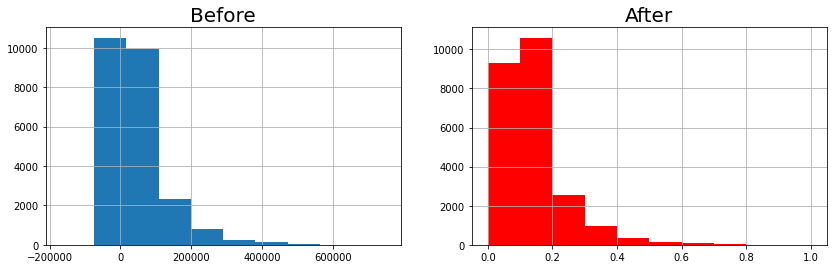

In [31]:
#MinMaxScalerのインスタンス化
min_max_scaler = preprocessing.MinMaxScaler()
# train
X_train_min_max = min_max_scaler.fit_transform(X_train)
# test trainを基準にしないとリークしてしまう
X_test_min_max = min_max_scaler.transform(X_test)

#分布描画
fontdic = {'size': 20}
plt.figure(figsize=(14, 4))
#変換前
plt.subplot(1, 2, 1)
plt.hist(X_train['BILL_AMT1'])
plt.title('Before', fontdict=fontdic)
plt.grid()
#変換後
plt.subplot(1, 2, 2)
plt.hist(X_train_min_max[:, 8], color='red')
plt.title('After', fontdict=fontdic)
plt.grid()

## Zスコア標準化
特徴量を平均０分散となるように変換します。

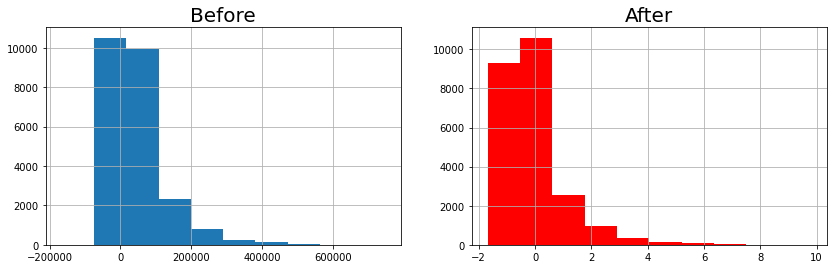

In [32]:
#zスコア変換
standard_scaler = preprocessing.StandardScaler()  
# train
X_train_standard = standard_scaler.fit_transform(X_train)
# test trainを基準にしないとリークしてしまう
X_test_standard = standard_scaler.transform(X_test)

#分布描画
fontdic = {'size': 20}
plt.figure(figsize=(14, 4))
#変換前
plt.subplot(1, 2, 1)
plt.hist(X_train['BILL_AMT1'])
plt.title('Before', fontdict=fontdic)
plt.grid()
#変換後
plt.subplot(1, 2, 2)
plt.hist(X_train_standard[:, 8], color='red')
plt.title('After', fontdict=fontdic)
plt.grid()

## 10進スケールの正規化
対象変数の絶対値が最大値が１以下になるように１０の乗数で除する方法です。

In [33]:
# 該当する関数がないので関数を定義
# 10進法の変換関数
def decimal_fit_trans(x):
    #絶対値の最大値をカラムごとに取得
    temp = np.nanmax(np.abs(x.values),axis=0)
    print("temp", temp)
    arr = np.array([])
    #カラムごとに除する定数を取得
    for t in temp:
        i = 0
        while t/10**(i) > 1:
            i += 1
        # np.r_はhstack、np.c_はvstackと同様の使い方をする。
        arr = np.r_[arr,1/10**(i)]
    return  (arr)

temp [8.000000e+05 8.000000e+00 7.000000e+00 8.000000e+00 8.000000e+00
 8.000000e+00 8.000000e+00 7.468140e+05 7.439700e+05 1.664089e+06
 7.068640e+05 8.235400e+05 6.999440e+05 8.735520e+05 1.684259e+06
 8.890430e+05 6.210000e+05 3.880710e+05 5.271430e+05]
temp [8.000000e+05 8.000000e+00 7.000000e+00 8.000000e+00 8.000000e+00
 8.000000e+00 8.000000e+00 7.468140e+05 7.439700e+05 1.664089e+06
 7.068640e+05 8.235400e+05 6.999440e+05 8.735520e+05 1.684259e+06
 8.890430e+05 6.210000e+05 3.880710e+05 5.271430e+05]


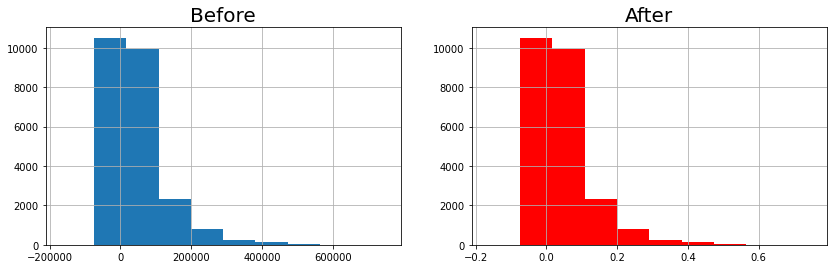

In [34]:
X_train_decimal = X_train*decimal_fit_trans(X_train)
X_test_decimal = X_test*decimal_fit_trans(X_train)
#分布描画
fontdic = {'size':20}
plt.figure(figsize=(14,4))
#変換前
plt.subplot(1,2,1)
plt.hist(X_train['BILL_AMT1'])
plt.title('Before',fontdict=fontdic)
plt.grid()
#変換後
plt.subplot(1,2,2)
plt.hist(X_train_decimal['BILL_AMT1'],color='red')
plt.title('After',fontdict=fontdic)
plt.grid()

## スケーリング方法比較

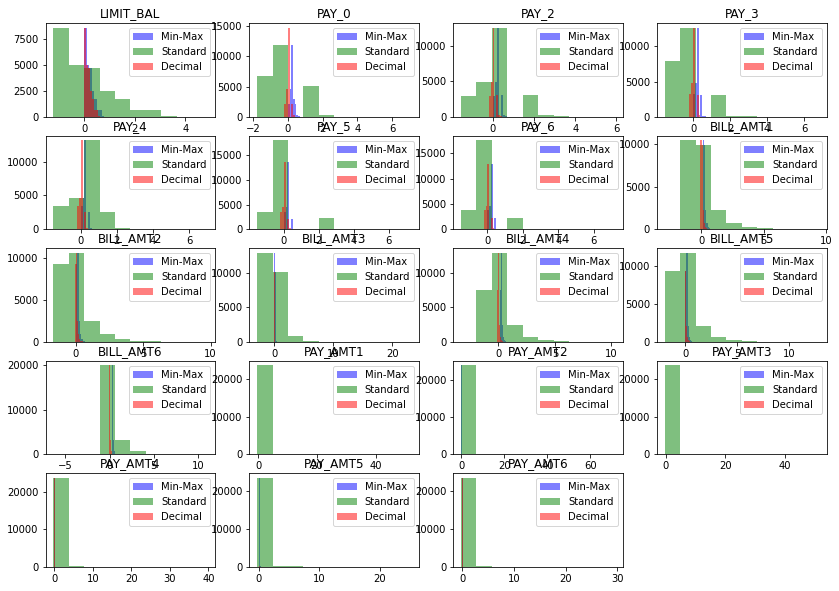

In [35]:
#変換後比較
plt.figure(figsize=(14, 10))
for i, col in enumerate(X_train.columns):
    plt.subplot(5, 4, i + 1)
    plt.hist(
        pd.DataFrame(X_train_min_max, columns=X_train.columns)[col],
        color='blue',
        alpha=0.5,
        label='Min-Max')
    plt.hist(
        pd.DataFrame(X_train_standard, columns=X_train.columns)[col],
        color='green',
        alpha=0.5,
        label='Standard')
    plt.hist(X_train_decimal[col], color='red', alpha=0.5, label='Decimal')
    plt.title(col)
    plt.legend()

In [36]:
#モデルの生成
clf = LogisticRegression()
# 精度を格納するリスト
l = []
# 学習
#スケーリングなし
clf.fit(X_train, y_train)
l.append(accuracy_score(y_test, clf.predict(X_test)))
#min_max変換
clf.fit(X_train_min_max, y_train)
l.append(accuracy_score(y_test, clf.predict(X_test_min_max)))
#zスコア変換
clf.fit(X_train_standard, y_train)
l.append(accuracy_score(y_test, clf.predict(X_test_standard)))
#10進変換
clf.fit(X_train_decimal, y_train)
l.append(accuracy_score(y_test, clf.predict(X_test_decimal)))
# 精度一覧
print(l)

[0.7838333333333334, 0.8145, 0.817, 0.8141666666666667]


# Chapter 2-8 データ変換

## 線形変換
変数のグループで線型結合し新たな変数とします。  
通常の回帰モデルやロジスティック回帰などの一般化線形モデルはリンク関数を通して、  
変数に対して線形性を持っているので、変数の削減以上の効果は期待できない。  
一方、データが周期性を持つ時系列の性質を持っている場合は有効になります。


## 二次型変換  
直線のデータだけが上手くいくとは限らないなので、その時はこの方法を試す。

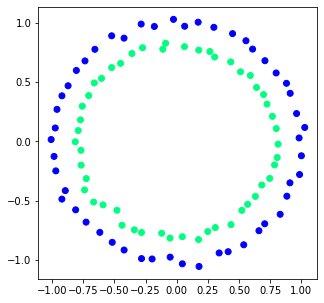

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#人工データを作成
from sklearn.datasets import make_circles

X, y = make_circles(noise=0.02, random_state=0)  #ラベル付き円を作成
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

In [38]:
# ロジスティック回帰で分類
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#x軸y軸を説明変数としてロジスティック回帰を適用
clf = LogisticRegression()
X_train = X
y_train = y
clf.fit(X_train, y_train)
accuracy_score(y_train, clf.predict(X_train))

0.5

In [39]:
#2次変換
#モデルの生成
clf_q = LogisticRegression()
Z = (X[:, 0]**(2) + X[:, 1]**(2)).reshape(-1, 1)
X_train = Z
y_train = y
clf_q.fit(X_train, y_train)
accuracy_score(y_train, clf_q.predict(X_train))

1.0

In [40]:
clf.coef_[:,1]

array([-0.00330446])

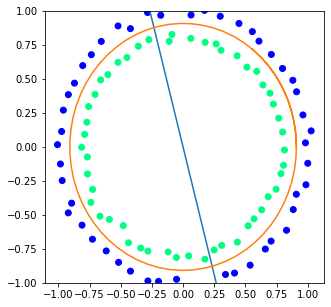

In [41]:
plt.figure(figsize=(5,5))
#通常の方法
x_=np.linspace(-1,1,100)
plt.scatter(X[:,0],X[:,1],c=y,cmap='winter')
#log(p/(1-p)=1/2となる線を描画する（coef_:回帰変数、 intercept_ : 切片)
plt.plot(x_,(-1*(clf.coef_[:,0]*x_)-clf.intercept_)/clf.coef_[:,1])
plt.ylim([-1,1])

#2次変換
theta = np.arange(0,2*np.pi+1,0.1)
xlist=[];ylist=[]
r =  ((clf_q.intercept_/(-1*clf_q.coef_))**(1/2))[0,0] #半径
for i in theta:
    xlist.append(r*np.cos(i))
    ylist.append(r*np.sin(i))
plt.plot(xlist,ylist)

## 変換の非多項式近似

- 比例変数 : 距離と時間から速さ
- GPSから得られる緯度経度データから移動距離を算出
- 三角形の三点データから同じものか異なるかを分類

様々な問題があり、ドメインの知識が重要になってくる。

## ランク変換

変数の値そのものではなく、その値が観測されたものの中での順位を用いて変数を変換する方法です。

作業手順  
1.全ての値に対して代償の順位を付けます。  
2.累積分布関数の逆関数を使い、求めた順位を正規分布に従うように変換します。  

回帰モデルなどの適用するときに有効。 (決定技などのモデルではなんの影響も与えません。）

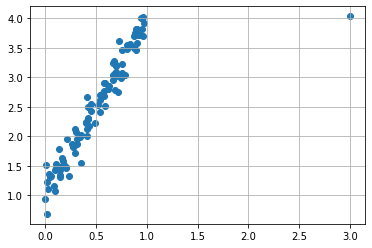

In [42]:
#人工的にデータを作成
#y ~ N(3x+1,0.2) に従う(x in [0,1])
np.random.seed(seed=1)
x = np.random.rand(100)
y = np.random.normal(3 * x + 1, 0.2)
#xの外れ値を作成
x = np.where(x == max(x), 3, x)
plt.scatter(x=x, y=y)
plt.grid()

In [43]:
#ランク算出のためのライブラリインポート
from scipy.stats import rankdata
#正規分布の累積分布関数の逆関数を計算するためにインポート
from scipy.stats import norm
#ランク変換関数定義
def rank_fit_transform(x):
  # norm.ppfの引数にはパーセンテージを取り、そのパーセンテージが発生する値の標準偏差乗数を返します。
  return (norm.ppf((rankdata(x) - (3 / 8)) / (len(x) + (1 / 4))))

In [44]:
#線形回帰モデルの準備
from sklearn import linear_model

#ランク変換前
clf = linear_model.LinearRegression()
X = x.reshape(-1, 1)
y = y
clf.fit(X, y)
clf.score(X, y)

#ランク変換後
clf_r = linear_model.LinearRegression()
X_r = rank_fit_transform(x).reshape(-1, 1)
y = y
clf_r.fit(X_r, y)
clf_r.score(X_r, y)
#決定係数
print("変換前_{:.5g}".format(clf.score(X, y)), "変換後_{:.5g}".format(
	clf_r.score(X_r, y)))

変換前_0.71387 変換後_0.91283


Text(0.5, 1.0, 'After')

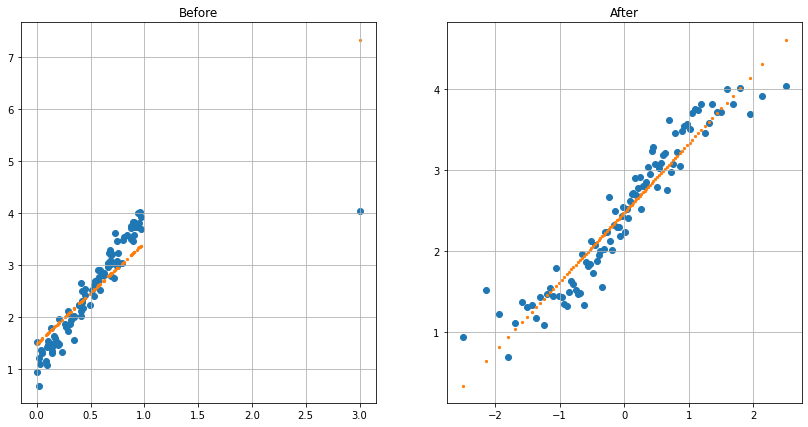

In [45]:
#直線当てはめを描画
plt.figure(figsize=(14, 7))
#変換なし
plt.subplot(1,2,1)
plt.scatter(X, y)
plt.scatter(X, clf.predict(X), s=5) # 線の描写
plt.grid()
plt.title('Before')
#ランク変換後
plt.subplot(1,2,2)
plt.scatter(X_r, y)
plt.scatter(X_r, clf_r.predict(X_r), s=5) # 線の描写
plt.grid()
plt.title('After')

## Box-Cox変換 (scipyを使用)
1/2乗したり対数を取ったりする変数を一般化したもの。  
右に長いテールを持つ分布や目的変数との非戦毛な関係を記述するために使います。

代表的な方法にLOG変換などがある。

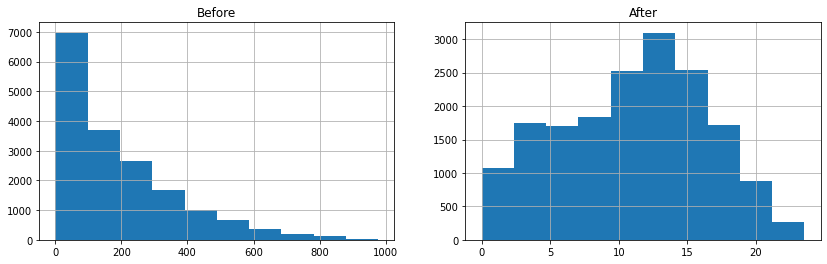

In [46]:
#必要なライブラリ読み込む
from scipy import stats  #boxcox変換のため
from sklearn import linear_model  #線形回帰モデル
from sklearn.model_selection import train_test_split  #訓練データ分割
#UCI よりレンタル自転車のデータを読み込む
df = pd.read_csv('./genbapro_preprocessing/chapter2-data/hour.csv')
#描画準備
plt.figure(figsize=(14, 4))
#cntの変換前ヒストグラム
plt.subplot(1, 2, 1)
plt.hist(df['cnt'])
plt.title('Before')
plt.grid()

#box-cox変換後の分布
plt.subplot(1, 2, 2)
bc, _ = stats.boxcox(df['cnt'])
plt.hist(bc)
plt.title('After')
plt.grid()

In [47]:
#データを訓練データとテストデータに分離
X = df['temp'].values
y = df['cnt'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#boxcox変換
y_train_bc, lambd = stats.boxcox(y_train)

#変換前回帰
clf = linear_model.LinearRegression()
clf.fit(X_train.reshape(-1, 1), y_train.reshape(-1, 1))

#変換後回帰
clf_bc = linear_model.LinearRegression()
clf_bc.fit(X_train.reshape(-1, 1), y_train_bc.reshape(-1, 1))

LinearRegression()

Text(0.5, 1.0, 'After')

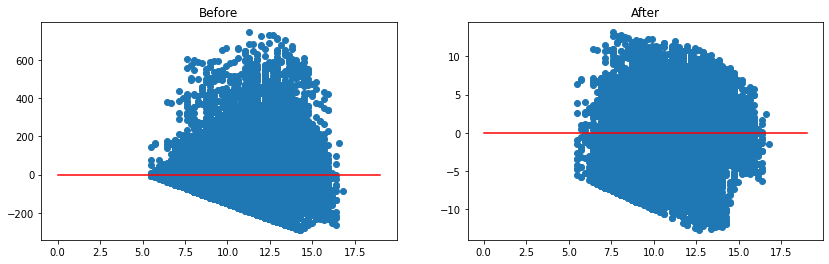

In [48]:
#残差プロット
#比較用y=0の線
x = np.arange(0, 20)
y = 0 * x

plt.figure(figsize=(14, 4))
#変換前
plt.subplot(1,2,1)
plt.scatter(
    clf_bc.predict(X_train.reshape(-1, 1)),
    y_train.reshape(-1, 1) - clf.predict(X_train.reshape(-1, 1)))
plt.plot(x, y, color='red')
plt.title('Before')
#変換後
plt.subplot(1,2,2)
plt.scatter(
    clf_bc.predict(X_train.reshape(-1, 1)),
    y_train_bc.reshape(-1, 1) - clf_bc.predict(X_train.reshape(-1, 1)))
plt.plot(x, y, color='red')
plt.title('After')

# Chapter 2-9 次元削除法

特徴量が増える事は機械学習にとって説得力が増す良い傾向にあるが、  
高次元の世界では低次元の直感に反することが起こる。  
- データが巨大で計算量が大きくなる。
- 次元の呪いで上手く学習できない。

## 主成分分析（PCA)

相関にある特徴量同士を合成して、なるべく情報量を失う事なく次元を削除する方法。  
次元削除の目安として、削除前の次元の80%以上の情報量が得られること。

In [49]:
from sklearn.decomposition import PCA  #主成分分析
#ESTAT 県民総生産 (2015)データ 読み込む
df = pd.read_csv('./genbapro_preprocessing/chapter2-data/FEI_PREF_2015.csv').set_index('地域')
#データ中身確認
df.head().T

地域,北海道,青森県,岩手県,宮城県,秋田県
農業,0.0321,0.0382,0.0256,0.0082,0.0235
林業,0.0013,0.0007,0.0038,0.0006,0.0040
水産業,0.0104,0.0061,0.0051,0.0044,0.0005
鉱業,0.0014,0.0022,0.0021,0.0012,0.0027
製造業,0.1041,0.1689,0.1421,0.1506,0.1516
建設業,0.0706,0.0661,0.1480,0.1279,0.0646
電気・ガス・水道・廃棄物処理業,0.0321,0.0283,0.0296,0.0258,0.0458
卸売・小売業,0.1289,0.1178,0.1051,0.1335,0.1039
金融・保険業,0.0344,0.0354,0.0375,0.0346,0.0391
不動産業,0.1104,0.1086,0.1122,0.1096,0.1283


(-0.05, 0.1)

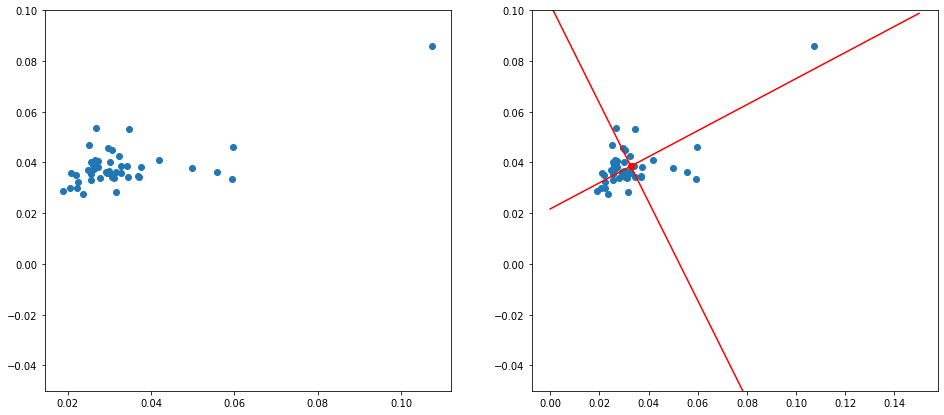

In [50]:
#PCA
pca = PCA()
pca.fit(df[['情報通信業', '金融・保険業']])

#図示する
fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.scatter(df['情報通信業'], df['金融・保険業'])
ax2.scatter(df['情報通信業'], df['金融・保険業'])
#第一主成分の軸を図示
y = (pca.components_[0][1] / pca.components_[0][0]) * (
	np.linspace(0, 0.15, 100) - np.mean(df['情報通信業'])) + np.mean(df['金融・保険業'])
ax2.plot(np.linspace(0, 0.15, 100), y, color='red')
#第二主成分の軸を図示
y = (pca.components_[1][1] / pca.components_[1][0]) * (
	np.linspace(0, 0.15, 100) - np.mean(df['情報通信業'])) + np.mean(df['金融・保険業'])
ax2.plot(np.linspace(0, 0.15, 100), y, color='red')
#中心を赤でplot
ax2.scatter(np.mean(df['情報通信業']), np.mean(df['金融・保険業']), color='red')
#目盛の範囲を調整
ax1.set_ylim(-0.05, 0.1)
ax2.set_ylim(-0.05, 0.1)

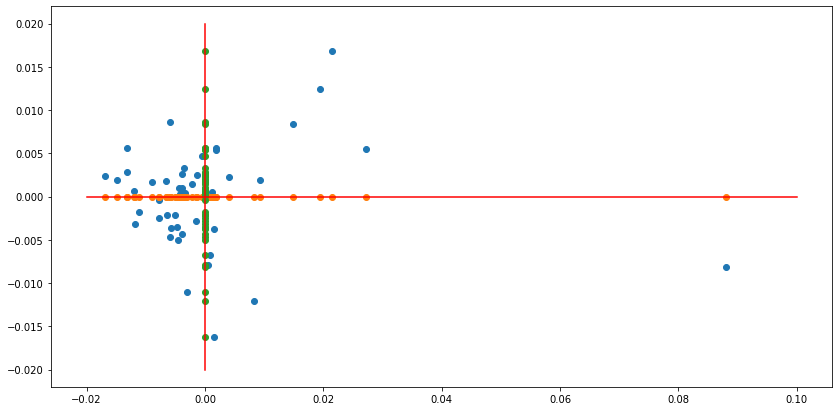

In [51]:
#新しい直交座標系でプロット
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 1, 1)
#元の系列
ax.scatter(
	pca.transform(df[['情報通信業', '金融・保険業']])[:, 0],
	pca.transform(df[['情報通信業', '金融・保険業']])[:, 1])
#第一主成分の座標
x = pca.transform(df[['情報通信業', '金融・保険業']])[:, 0]
y = x * 0
ax.scatter(x, y)
ax.plot(
	np.linspace(-0.02, 0.1, 100),
	np.linspace(-0.02, 0.02, 100) * 0,
	color='red')
#第二主成分の座標
y = pca.transform(df[['情報通信業', '金融・保険業']])[:, 1]
x = y * 0
ax.scatter(x, y)
ax.plot(
	np.linspace(-0.02, 0.1, 100) * 0,
	np.linspace(-0.02, 0.02, 100),
	color='red')

In [52]:
#寄与度
print (pca.explained_variance_ratio_)

[0.87637202 0.12362798]


## 因子分析

複数の相関する変数が、ある今日通院しより発生していると考え、この共通因子を求める手法。  
主成分分析と同様に相関係数行列の固有値の大きさを情報量とみなし、その値が１より大きいものの数を因子数として定めると良い。

In [53]:
#因子分析用のライブラリを読み込む
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt #可視化のため
import numpy.linalg as LA #固有値計算のため

#ESTAT 県民総生産 (2015)データ 読み込む
df = pd.read_csv('./genbapro_preprocessing/chapter2-data/FEI_PREF_2015.csv').set_index('地域')
U = df

ModuleNotFoundError: No module named 'factor_analyzer'

In [55]:
#固有値の大きさ
ev, _ = LA.eig(U.corr())  #相関係数行列の固有値
plt.bar(np.arange(len(ev)), ev)  #固有値プロット
plt.plot([1] * 20, color='red')  #比較用のy=1の線をプロット

NameError: name 'LA' is not defined

In [56]:
#因子分析のインスタンス作成
fa = FactorAnalyzer(rotation=None, n_factors=5)  #回転させない
#モデリング
fa.fit(U)

NameError: name 'FactorAnalyzer' is not defined

NameError: name 'U' is not defined

/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 31532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 22240 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 23376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 36000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 33655 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_

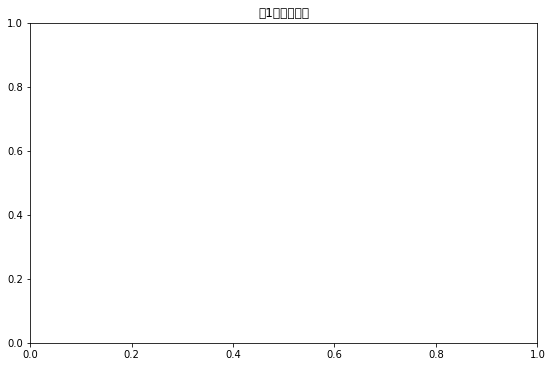

In [57]:
#因子負荷量 プロット
fig = plt.figure(figsize=(20,20))
#ax = []
for i in np.arange(5):
    ax = fig.add_subplot(3,2,i+1)
    plt.title('第'+str(i+1)+'因子負荷量')
    ax.bar([i[0:2] for i in U.columns],fa.loadings_[:,i]) #ラベルの先頭2文字のみ出力

## 多次元尺度構成法

距離の外面を用意てデータを低次元にマッピングする手法。  
連続的な間隔尺度のみでなく、アンケート後段階評価のような順序尺度に対しても適用可能です。

In [58]:
#多次元尺度構成法ライブラリ読み込む
from sklearn.manifold import MDS
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt

#ワインデータ読み込み
data = load_wine()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

#MDSインスタンス作成しfitさせる
embedding = MDS(
	n_components=2, metric=True,
	random_state=1)  #metricのデフォルトはTrue 間隔尺度であるため計量MDSを実行
X_mds = embedding.fit_transform(X)

([<matplotlib.axis.XTick at 0xffff58371850>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 20803 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12488 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12524 missing from current font.
  font.set_

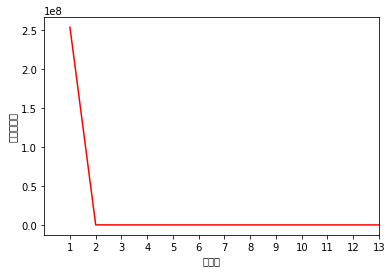

In [59]:
#次元ごとのストレス値
l = []
for i in np.arange(len(X.columns)):
	embedding = MDS(
    	n_components=i + 1, metric=True,
    	random_state=1)  #metricのデフォルトはTrue 間隔尺度であるため計量MDSを実行
	X_mds = embedding.fit_transform(X)
	l.append(embedding.stress_)

plt.plot(np.arange(len(X.columns)) + 1, l, color='red')
plt.xlabel('次元数')
plt.ylabel('ストレス値')
plt.xlim(0, 13)
plt.xticks(np.arange(len(X.columns)) + 1)

２次元以降のストレスフリーなので、２次元にマッピングが妥当！！

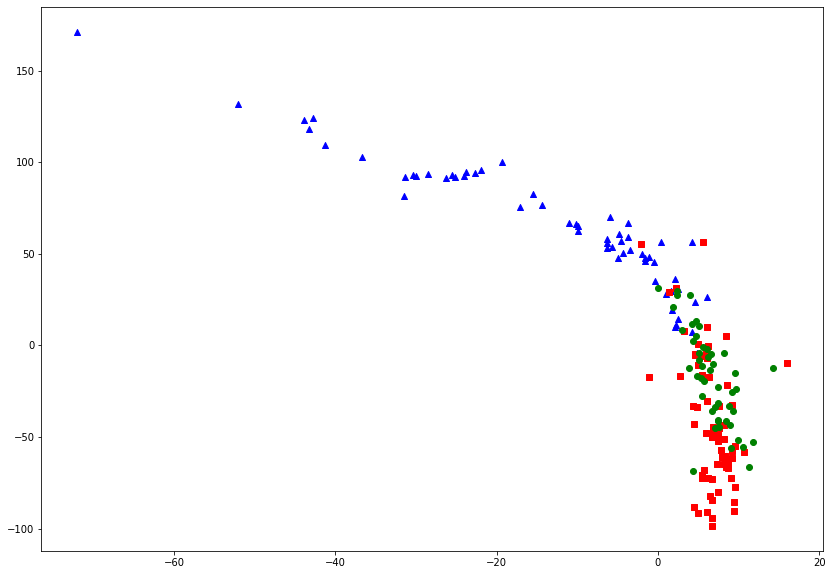

In [60]:
#2次元に配置する
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(1, 1, 1)
X_mds[y == 0, 0]
for i, j, k in zip(np.arange(3), ['blue', 'red', 'green'], ['^', 's', 'o']):
	ax.scatter(X_mds[y == i, 0], X_mds[y == i, 1], color=j, marker=k)

局所不可

# Chapter 2-10 特徴量選択

特徴量の中から重要なものを探し、不要なものを取り除くプロセス。  
- モデルの精度向上
- モデル構築時間の短縮化
- モデルの可視化、理解の容易化

### 特徴量選択の３手法
- fitter法 計算コストが少ない。
- Wrapper法 変数間の相互の影響を考慮できる。
- Embedded法 学習モデルのアルゴリズムを使用。 Wrapperよりは計算コストが少ない。

In [61]:
#データをトレーニング・テストに分けるモジュール
from sklearn.model_selection import train_test_split
#ロジスティック回帰モデル
from sklearn.linear_model import LogisticRegression
#正答率算出
from sklearn.metrics import accuracy_score
#category encoder インポート
import category_encoders as ce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#データ 読み込み
df_adult = df_adult_m.copy()

#ターゲット変数1/0エンコーディング
df_adult['Income'] = (df_adult['Income'] == ' >50K').astype(int)
#特徴量取得
X_adult = df_adult.drop(['Income'], axis=1)
#ターゲット変数を取得
y_adult = df_adult['Income']
#訓練・検証データを分離
X_adult_train, X_adult_test, y_adult_train, y_adult_test = train_test_split(
    X_adult, y_adult, test_size=0.2, random_state=1)

#ターゲットエンコーダ インスタンス化
encoder = ce.TargetEncoder(cols=['Education', 'Occupation', 'NativeCountry'])
enc = encoder.fit(X_adult_train, y_adult_train)
X_adult_train = enc.transform(X_adult_train)
X_adult_test = enc.transform(X_adult_test)

#One-Hotエンコーディング インスタンス化
encoder = ce.OneHotEncoder(
    cols=['WorkClass', 'MaritalStatus', 'Relationship', 'Race', 'Gender'],
    use_cat_names=True)
enc = encoder.fit(X_adult_train)
X_adult_train = enc.transform(X_adult_train)
X_adult_test = enc.transform(X_adult_test)

#One-Hotエンコーディングで冗長になった変数を落とす
drop_l = [
    [col for col in X_adult_train.columns if col.find('WorkClass') >= 0][0], [
        col for col in X_adult_train.columns if col.find('MaritalStatus') >= 0
    ][0], [
        col for col in X_adult_train.columns if col.find('Relationship') >= 0
    ][0], [col for col in X_adult_train.columns if col.find('Race') >= 0][0],
    [col for col in X_adult_train.columns if col.find('Gender') >= 0][0]
]
X_adult_train = X_adult_train.drop(drop_l, axis=1)
X_adult_test = X_adult_test.drop(drop_l, axis=1)

ModuleNotFoundError: No module named 'category_encoders'

In [62]:
#すべての特徴量
features_all = X_adult_train.columns
print('特徴量 : {} '.format(features_all))
#比較用として全ての特徴量でモデル作成
#フルモデルと比較
reg = LogisticRegression().fit(X_adult_train, y_adult_train)
score_all = accuracy_score(y_adult_test, reg.predict(X_adult_test))
print('訓練 : {} '.format(
    accuracy_score(y_adult_train, reg.predict(X_adult_train))))
print('検証 : {} '.format(
    accuracy_score(y_adult_test, reg.predict(X_adult_test))))

特徴量 : Index(['Age', 'WorkClass', 'fnlwgt', 'Education', 'EducationNum',
       'MaritalStatus', 'Occupation', 'Relationship', 'Race', 'Gender',
       'CapitalGain', 'CapitalLoss', 'HoursPerWeek', 'NativeCountry'],
      dtype='object') 


ValueError: could not convert string to float: ' Self-emp-not-inc'

### Filter法 
単一の特徴量とターゲット変数tの関係の強弱で特徴量を選択。  
モデル学習の前に変数をより分けられるからこの名がついた。  
ターゲット変数と特徴量の何かしらの尺度で評価して遠別する。

- 分散   特徴調のみで判断試合場合。全特徴量のスケールが同じ場合。
- ピアソンの相関関係  特徴りょう、ターゲット変数が数値の場合。
- x^2統計量  特徴量、ターゲット編数がカテゴリ軽変数の場合。
- F値　　特徴量が数値orカテゴリ変数、ターゲットヘンスが数値orカテゴリ軽変数の場合。

In [63]:
#単変量Filterモジュール読み込む
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, chi2

#F値でfeature selection filter法
tr_score = []  #訓練スコアを入れるリスト
te_score = []  #検証スコアを入れるリスト
features = []  #特徴量を入れるりスト

#Kごとに精度評価
for i in np.arange(len(X_adult_train.columns)):
    
    sel = SelectKBest(f_classif, k=i + 1).fit(X_adult_train, y_adult_train)
    X_train_sel = sel.transform(X_adult_train)
    X_test_sel = sel.transform(X_adult_test)
    
    reg = LogisticRegression().fit(X_train_sel, y_adult_train)
    
    tr_score.append(accuracy_score(y_adult_train, reg.predict(X_train_sel)))
    te_score.append(accuracy_score(y_adult_test, reg.predict(X_test_sel)))
    features.append(X_adult_train.columns[sel.get_support()])

#kごとに精度がどのように変わったか可視化する
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(X_adult_train.columns)) + 1, tr_score, label='Train')
plt.plot(np.arange(len(X_adult_train.columns)) + 1, te_score, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('The Number of features')
plt.xticks(np.arange(1, 1 + len(X_adult_train.columns)))
plt.legend(fontsize=14)
plt.grid()
plt.title('Feature selection by using F value')

ValueError: could not convert string to float: ' Self-emp-not-inc'

In [64]:
#訓練データの精度最大となるk
print (tr_score.index(np.max(tr_score)))

ValueError: zero-size array to reduction operation maximum which has no identity

In [65]:
#訓練データで精度最大になる変数の数と組み合わせ
features_sel_filter = features[tr_score.index(np.max(tr_score))]
print ('特徴量 : {} '.format(features_sel_filter))
print ('訓練 : {} '.format((tr_score[tr_score.index(np.max(tr_score))])))
print ('検証 : {} '.format((te_score[tr_score.index(np.max(tr_score))])))

ValueError: zero-size array to reduction operation maximum which has no identity

### Warpper法  
特徴量の集合毎にモデルを作成しその精度を元に特徴量を選択。  
- SFG  空集合からモデル制度のような基準に従って特徴料をつい介していく方法。
- SBG  特徴量全ての集合から開始し、最も重要ではない変数を一つずつ取り除く方法。
- stepwise  SFGとSBGを同時に行う方法。　

In [66]:
#wrapper法実行モジュール読み込む
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

ModuleNotFoundError: No module named 'mlxtend'

### Sequence Forward Generation

In [71]:
#SFSインスタンス化
sfs = SFS(LogisticRegression(),  #利用するモデル
           k_features=(1,33), #特徴量の数 1-33個の間でCVスコアベストを探す
           forward=True, #フォワード型
           floating=False, #フローティングの有無
           verbose=2,
           scoring='accuracy',#精度指標
           cv=5,
          n_jobs=-1)

sfs = sfs.fit(X_adult_train, y_adult_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  33 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    1.1s finished

[2021-04-10 04:30:05] Features: 1/33 -- score: 0.7969134699318948[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    1.8s finished

[2021-04-10 04:30:07] Features: 2/33 -- score: 0.8104267713233666[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    2.4s finished

[2021-04-10 04:30:10] Features: 3/33 -- score: 0.8114633796739661[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.2s finished

[2021-04-10 04:30:12] Features: 4/33 -- score: 0.8116939344239945[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent 

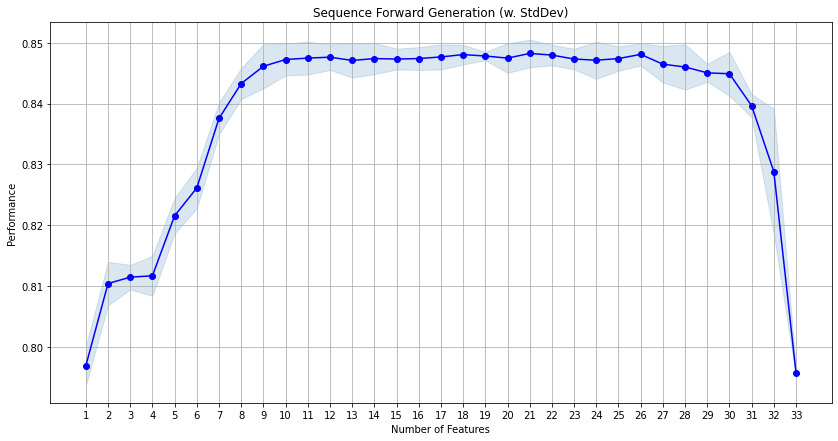

In [72]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(14, 7))
plt.title('Sequence Forward Generation (w. StdDev)')
plt.grid()

In [73]:
#選ばれた特徴量のサブセットでモデルを作成
features_sel_wrapper_sfg = list(sfs.k_feature_names_)
reg = LogisticRegression().fit(X_adult_train[features_sel_wrapper_sfg],
                               y_adult_train)
print('特徴量 : {} '.format(features_sel_wrapper_sfg))
print('訓練 : {} '.format(
    accuracy_score(y_adult_train,
                   reg.predict(X_adult_train[features_sel_wrapper_sfg]))))
print('検証 : {} '.format(
    accuracy_score(y_adult_test,
                   reg.predict(X_adult_test[features_sel_wrapper_sfg]))))
score_sel_wrapper_sfg = accuracy_score(
    y_adult_test, reg.predict(X_adult_test[features_sel_wrapper_sfg]))

特徴量 : ['WorkClass_ State-gov', 'WorkClass_ ?', 'WorkClass_ Federal-gov', 'WorkClass_ Local-gov', 'WorkClass_ Self-emp-inc', 'WorkClass_ Never-worked', 'WorkClass_ Without-pay', 'Education', 'EducationNum', 'MaritalStatus_ Divorced', 'MaritalStatus_ Married-spouse-absent', 'Occupation', 'Relationship_ Not-in-family', 'Relationship_ Other-relative', 'Relationship_ Unmarried', 'Relationship_ Own-child', 'Race_ Other', 'Race_ Amer-Indian-Eskimo', 'CapitalGain', 'CapitalLoss', 'NativeCountry'] 
訓練 : 0.8474738943488943 
検証 : 0.8475356978350991 


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Sequential Backward Generation

In [74]:
#SFSインスタンス化
sbs = SFS(LogisticRegression(),  #利用するモデル
           k_features=(1,33), #特徴量の数 1-33個の間でCVスコアベストを探す
           forward=False, #バックワード型
           floating=False, #フローティングの有無
           verbose=2,
           scoring='accuracy',#精度指標
           cv=5,
          n_jobs=-1)

sbs = sbs.fit(X_adult_train, y_adult_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    4.8s finished

[2021-04-10 04:31:35] Features: 32/1 -- score: 0.8288157990249416[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    7.3s finished

[2021-04-10 04:31:42] Features: 31/1 -- score: 0.8396422108641877[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    7.1s finished

[2021-04-10 04:31:49] Features: 30/1 -- score: 0.8449015858791571[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.2s finished

[2021-04-10 04:31:56] Features: 29/1 -- score: 0.8458229647564804[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    7.1s finished



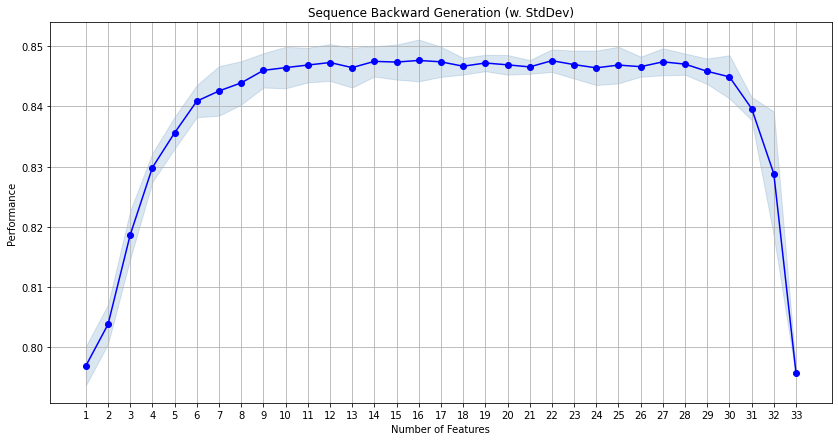

In [75]:
fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev', figsize=(14, 7))
plt.title('Sequence Backward Generation (w. StdDev)')
plt.grid()

In [76]:
#選ばれた特徴量のサブセットでモデルを作成
features_sel_wrapper_sbg = list(sbs.k_feature_names_)
reg = LogisticRegression().fit(X_adult_train[features_sel_wrapper_sbg],
                               y_adult_train)
print('特徴量 : {} '.format(features_sel_wrapper_sbg))
print('訓練 : {} '.format(
    accuracy_score(y_adult_train,
                   reg.predict(X_adult_train[features_sel_wrapper_sbg]))))
print('検証 : {} '.format(
    accuracy_score(y_adult_test,
                   reg.predict(X_adult_test[features_sel_wrapper_sbg]))))
score_sel_wrapper_sbg = accuracy_score(
    y_adult_test, reg.predict(X_adult_test[features_sel_wrapper_sbg]))

特徴量 : ['WorkClass_ Federal-gov', 'WorkClass_ Local-gov', 'WorkClass_ Self-emp-inc', 'EducationNum', 'MaritalStatus_ Never-married', 'MaritalStatus_ Divorced', 'MaritalStatus_ Widowed', 'MaritalStatus_ Separated', 'Occupation', 'Relationship_ Not-in-family', 'Relationship_ Other-relative', 'Relationship_ Own-child', 'Race_ Other', 'Race_ Amer-Indian-Eskimo', 'CapitalGain', 'CapitalLoss'] 
訓練 : 0.8470899877149877 
検証 : 0.8478427759864886 


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Bidirectional Generation



In [78]:
#SFSインスタンス化
sfsf = SFS(
    LogisticRegression(),  #利用するモデル
    k_features=(1, 33),  #特徴量の数 1-33個の間でCVスコアベストを探す
    forward=True,  #フォワード型
    floating=True,  #フローティングの有無 Trueとする
    verbose=2,
    scoring='accuracy',  #精度指標
    cv=5,
    n_jobs=-1)

sfsf = sfsf.fit(X_adult_train, y_adult_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    0.6s finished

[2021-04-10 04:33:27] Features: 1/33 -- score: 0.7969134699318948[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished

[2021-04-10 04:33:28] Features: 2/33 -- score: 0.8104267713233666[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished

[2021-04-10 04:33:31] Features: 3/33 -- score: 0.8114633796739661[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent 

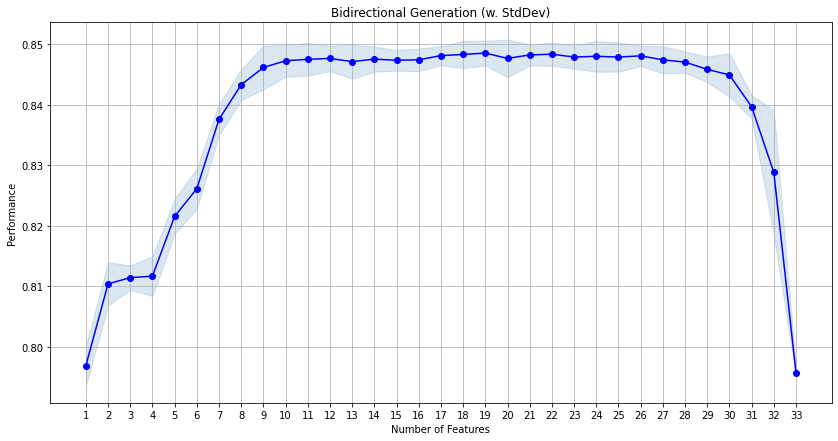

In [79]:
fig1 = plot_sfs(sfsf.get_metric_dict(), kind='std_dev', figsize=(14, 7))
plt.title('Bidirectional Generation (w. StdDev)')
plt.grid()

In [80]:
#選ばれた特徴量のサブセットでモデルを作成
features_sel_wrapper_bg = list(sfsf.k_feature_names_)
reg = LogisticRegression().fit(X_adult_train[features_sel_wrapper_bg],
                               y_adult_train)
print('特徴量 : {} '.format(features_sel_wrapper_bg))
print('訓練 : {} '.format(
    accuracy_score(y_adult_train,
                   reg.predict(X_adult_train[features_sel_wrapper_bg]))))
print('検証 : {} '.format(
    accuracy_score(y_adult_test,
                   reg.predict(X_adult_test[features_sel_wrapper_bg]))))
score_sel_wrapper_bg = accuracy_score(
    y_adult_test, reg.predict(X_adult_test[features_sel_wrapper_bg]))

特徴量 : ['WorkClass_ State-gov', 'WorkClass_ Federal-gov', 'WorkClass_ Self-emp-inc', 'WorkClass_ Never-worked', 'WorkClass_ Without-pay', 'Education', 'EducationNum', 'MaritalStatus_ Divorced', 'MaritalStatus_ Married-spouse-absent', 'MaritalStatus_ Married-AF-spouse', 'Occupation', 'Relationship_ Not-in-family', 'Relationship_ Other-relative', 'Relationship_ Unmarried', 'Relationship_ Own-child', 'Race_ Amer-Indian-Eskimo', 'CapitalGain', 'CapitalLoss', 'NativeCountry'] 
訓練 : 0.8485488329238329 
検証 : 0.8476892369107938 


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Embedded法

Lass回帰やTreeベースモデルの学習アルゴリズム内で特徴量を計算し、  
アルゴリズム自らが特徴量を選択する。これを用意て特徴量の組み合わせを見つける手法。  
組み合わせ1つ１つに対して再学習しないので学習コストも減らせる。

In [81]:
#SelectFromModelモジュール読み込み
from sklearn.feature_selection import SelectFromModel
#標準化モジュール読み込む
from sklearn.preprocessing import StandardScaler

### Lasso回帰

In [82]:
#標準化
scaler = StandardScaler()
scaler.fit(X_adult_train)
X_adult_train_standard = scaler.transform(X_adult_train)
X_adult_test_standard = scaler.transform(X_adult_test)

In [83]:
#lasso selectFromModelインスタンス作成
embeded_selector = SelectFromModel(
    LogisticRegression(C=1.0, penalty="l1", solver='liblinear'),
    threshold='mean')
embeded_selector.fit(X_adult_train_standard, y_adult_train)

SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='liblinear'),
                threshold='mean')

In [84]:
#選ばれた特徴量のサブセットでモデルを作成
features_sel_embedded_lasso = X_adult_train.columns[
    embeded_selector.get_support()]
reg = LogisticRegression()
#モデル作成
reg.fit(embeded_selector.transform(X_adult_train), y_adult_train)
print('特徴量 : {} '.format(features_sel_embedded_lasso))
print('訓練 : {} '.format(
    accuracy_score(y_adult_train,
                   reg.predict(embeded_selector.transform(X_adult_train)))))
print('検証 : {} '.format(
    accuracy_score(y_adult_test,
                   reg.predict(embeded_selector.transform(X_adult_test)))))
score_sel_embedded_lasso = accuracy_score(
    y_adult_test, reg.predict(embeded_selector.transform(X_adult_test)))

特徴量 : Index(['Age', 'EducationNum', 'MaritalStatus_ Never-married',
       'MaritalStatus_ Divorced', 'MaritalStatus_ Separated', 'Occupation',
       'Relationship_ Own-child', 'Relationship_ Wife', 'Gender_ Female',
       'CapitalGain', 'HoursPerWeek'],
      dtype='object') 
訓練 : 0.836916461916462 
検証 : 0.8347919545524336 


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### RandomForest

In [85]:
#RaondomForest
from sklearn.ensemble import RandomForestClassifier

#RondomForest SelectFromModelインスタンス作成
embeded_selector = SelectFromModel(
    RandomForestClassifier(
        n_estimators=100, random_state=0, min_samples_leaf=50), "mean")
embeded_selector.fit(X_adult_train, y_adult_train)

#選ばれた特徴量のサブセットでモデルを作成
features_sel_embedded_rf = X_adult_train.columns[
    embeded_selector.get_support()]
reg = LogisticRegression()
#モデル作成
reg.fit(embeded_selector.transform(X_adult_train), y_adult_train)
print('特徴量 : {} '.format(features_sel_embedded_rf))
print('訓練 : {} '.format(
    accuracy_score(y_adult_train,
                   reg.predict(embeded_selector.transform(X_adult_train)))))
print('検証 : {} '.format(
    accuracy_score(y_adult_test,
                   reg.predict(embeded_selector.transform(X_adult_test)))))
score_sel_embedded_rf = accuracy_score(
    y_adult_test, reg.predict(embeded_selector.transform(X_adult_test)))

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=mean as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


特徴量 : Index(['Age', 'Education', 'EducationNum', 'MaritalStatus_ Never-married',
       'MaritalStatus_ Divorced', 'Occupation', 'Relationship_ Not-in-family',
       'Gender_ Female', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek'],
      dtype='object') 
訓練 : 0.8215985872235873 
検証 : 0.8229694457239367 


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
